# Introduction to Convolutional Neural Networks with PyTorch

In this notebook, we will:
1. Load and visualize the CIFAR-10 dataset.
2. Build a Convolutional Neural Network (CNN) using PyTorch.
3. Train the CNN for image classification.
4. Evaluate performance.
5. Suggest improvements.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchmetrics
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:05<00:00, 31.4MB/s]


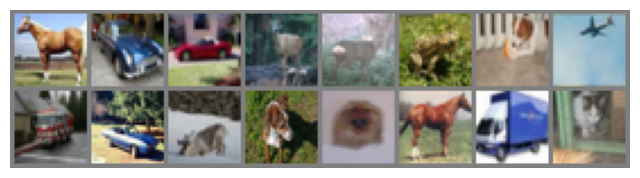

In [ ]:
# Function to show images
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:16]))

## Define the CNN architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training the CNN

In [ ]:
import torch.optim as optim
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define torchmetrics objects
metrics = {
    "train_acc": Accuracy(task="multiclass", num_classes=10).to(device),
    "train_prec": Precision(task="multiclass", num_classes=10, average="macro").to(device),
    "train_rec": Recall(task="multiclass", num_classes=10, average="macro").to(device),
    "test_acc": Accuracy(task="multiclass", num_classes=10).to(device),
    "test_prec": Precision(task="multiclass", num_classes=10, average="macro").to(device),
    "test_rec": Recall(task="multiclass", num_classes=10, average="macro").to(device),
}

# Training
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Reset train metrics each epoch
    metrics["train_acc"].reset()
    metrics["train_prec"].reset()
    metrics["train_rec"].reset()

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Update training metrics
        metrics["train_acc"].update(outputs, labels)
        metrics["train_prec"].update(outputs, labels)
        metrics["train_rec"].update(outputs, labels)

    # Compute train metrics
    train_acc = metrics["train_acc"].compute().item()
    train_prec = metrics["train_prec"].compute().item()
    train_rec = metrics["train_rec"].compute().item()

    # Reset test metrics
    metrics["test_acc"].reset()
    metrics["test_prec"].reset()
    metrics["test_rec"].reset()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            metrics["test_acc"].update(outputs, labels)
            metrics["test_prec"].update(outputs, labels)
            metrics["test_rec"].update(outputs, labels)

    # Compute test metrics
    test_acc = metrics["test_acc"].compute().item()
    test_prec = metrics["test_prec"].compute().item()
    test_rec = metrics["test_rec"].compute().item()

    # Log results
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(trainloader):.4f} | "
          f"Train Acc: {train_acc:.4f} | Train Prec: {train_prec:.4f} | Train Rec: {train_rec:.4f} | "
          f"Test Acc: {test_acc:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f}")

Epoch [1/10] | Loss: 1.4145 | Train Acc: 0.4885 | Train Prec: 0.4839 | Train Rec: 0.4885 | Test Acc: 0.5946 | Test Prec: 0.6137 | Test Rec: 0.5946
Epoch [2/10] | Loss: 1.0022 | Train Acc: 0.6458 | Train Prec: 0.6428 | Train Rec: 0.6458 | Test Acc: 0.6658 | Test Prec: 0.6707 | Test Rec: 0.6658
Epoch [3/10] | Loss: 0.8382 | Train Acc: 0.7062 | Train Prec: 0.7046 | Train Rec: 0.7062 | Test Acc: 0.6966 | Test Prec: 0.7115 | Test Rec: 0.6966
Epoch [4/10] | Loss: 0.7324 | Train Acc: 0.7410 | Train Prec: 0.7397 | Train Rec: 0.7410 | Test Acc: 0.7195 | Test Prec: 0.7359 | Test Rec: 0.7195
Epoch [5/10] | Loss: 0.6577 | Train Acc: 0.7700 | Train Prec: 0.7690 | Train Rec: 0.7700 | Test Acc: 0.7302 | Test Prec: 0.7318 | Test Rec: 0.7302
Epoch [6/10] | Loss: 0.6019 | Train Acc: 0.7905 | Train Prec: 0.7896 | Train Rec: 0.7905 | Test Acc: 0.7302 | Test Prec: 0.7385 | Test Rec: 0.7302
Epoch [7/10] | Loss: 0.5440 | Train Acc: 0.8089 | Train Prec: 0.8083 | Train Rec: 0.8089 | Test Acc: 0.7460 | Test Pre

### Suggestions to reach 90% accuracy:

1. Try data augmentation to improve generalization.
2. Use learning rate schedulers for better training.
3. Add Dropout or BatchNorm for regularization.
4. Implement early stopping by monitoring the validation loss to prevent overfitting and automatically restore the best model.
5. Replace the CNN with a pretrained model like ResNet or MobileNet and:
    - Freeze the convolutional base, training only the classifier head.
    - Unfreeze the whole model and fine-tune it on CIFAR-10 for potentially better performance.